## Image GPT [https://openai.com/blog/image-gpt/](https://openai.com/blog/image-gpt/)

Demo notebook. Please follow the `Readme.md` file and install all the requiresments if you didn't already

In [ ]:
# Run to check your nvidia card memory (optional)
!nvidia-smi

In [64]:
import cv2
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shutil import copy2
from datetime import datetime

from src.np_utils import color_quantize_np, generate_primer
# from src.runner import run_preds

model_size = "m"  # ["s", "m", "l"] available (xl, which is used on the website, is not avaiable)
gpus = 1
n_samples = 4
size = 32  # depends on the model: 32, *48, *64 (48 and 64 are only avaiable with XL model)

model_dir = "models"
color_clusters_dir = "clusters"
timestamp = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')

### Download model (run only once, if you have a model stored in `{model_dir}` then skip)

Depends on your selection, get the right model and color cluster

_This might take a while depends on your internet connection_

In [8]:
# Uncomment this code to download model and color cluster
# !python download.py --model {model_size} --ckpt 1000000 --clusters --download_dir {model_dir}/{model_size}
# !python download.py --clusters --download_dir {color_clusters_dir}

input args:
 {
    "download_dir":"models/l-small",
    "bert":false,
    "model":"l",
    "ckpt":"131000",
    "clusters":true,
    "dataset":null
}
Fetching model.ckpt-131000.data-00000-of-00064: 1.00kit [00:00, 707kit/s]       
Fetching model.ckpt-131000.data-00001-of-00064: 252Mit [00:21, 11.5Mit/s]       
Fetching model.ckpt-131000.data-00002-of-00064: 249Mit [00:21, 11.5Mit/s]       
Fetching model.ckpt-131000.data-00003-of-00064: 249Mit [00:20, 12.0Mit/s]       
Fetching model.ckpt-131000.data-00004-of-00064: 274Mit [00:23, 11.6Mit/s]       
Fetching model.ckpt-131000.data-00005-of-00064: 255Mit [00:21, 12.0Mit/s]       
Fetching model.ckpt-131000.data-00006-of-00064: 255Mit [00:20, 12.6Mit/s]       
Fetching model.ckpt-131000.data-00007-of-00064: 264Mit [00:21, 12.2Mit/s]       
Fetching model.ckpt-131000.data-00008-of-00064: 245Mit [00:21, 11.6Mit/s]       
Fetching model.ckpt-131000.data-00009-of-00064: 258Mit [00:20, 12.5Mit/s]       
Fetching model.ckpt-131000.data-00010-of

## Get image and create inputs

In [10]:
# This one is optional if you don't have anything stored
!curl https://pbs.twimg.com/profile_images/679813946950455297/pAe9lV1V.jpg > test_input.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42497  100 42497    0     0   267k      0 --:--:-- --:--:-- --:--:--  267k


In [4]:
image_path = 'test_input.jpg' # Change this you you already have an image on your machine
batch = [image_path]*(gpus*n_samples)

dim=(size,size)

x = np.zeros((gpus*n_samples,size,size,3),dtype=np.uint8)

for n,image_path in enumerate(batch):
    img_np = cv2.imread(image_path)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)   # BGR -> RGB, default one is BGR and we need RGB
    H,W,C = img_np.shape
    D = min(H,W)
    img_np = img_np[:D,:D,:C] # crop square image with shorter dim
    x[n] = cv2.resize(img_np,dim, interpolation = cv2.INTER_AREA)

## Visualize batch

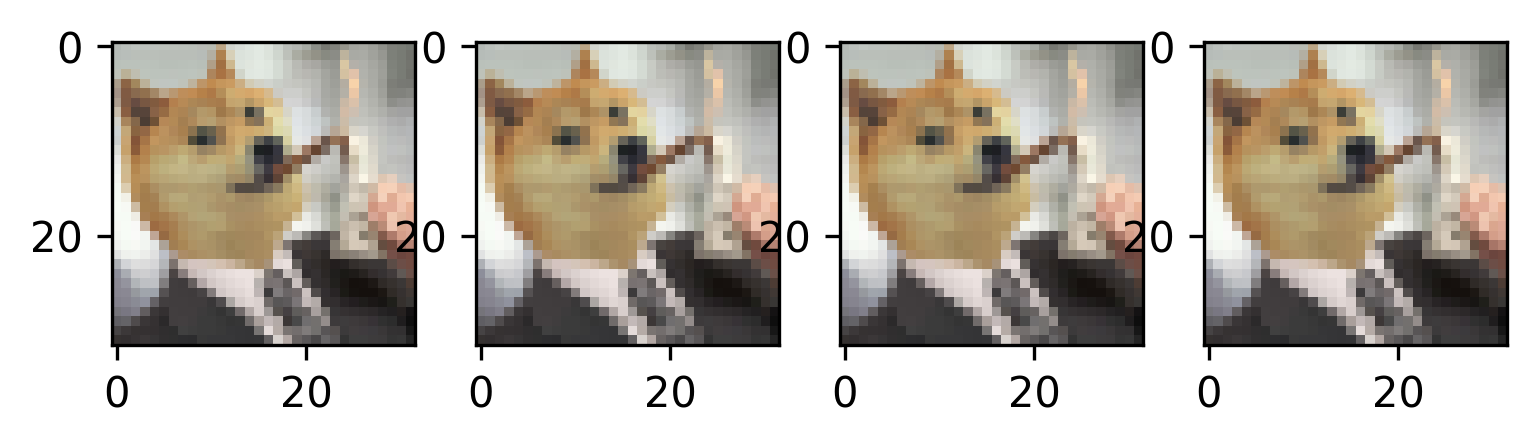

In [5]:
fig, ax = plt.subplots(1,n_samples, dpi=300)

i = 0
for img in x:
    ax[i].imshow(img)
    i += 1

In [7]:
color_cluster_path = f"{color_clusters_dir}/kmeans_centers.npy"
primers = generate_primer(image_path, n_samples, gpus, size, color_cluster_path)

## Visualize cropped images

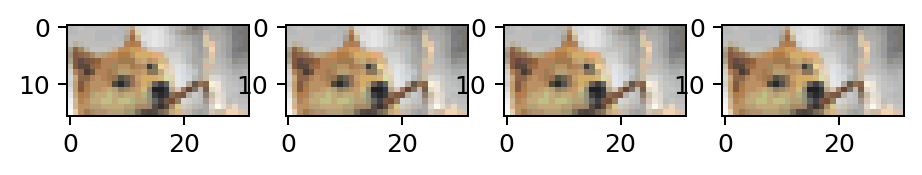

In [10]:
n_px_crop = 16 # do not change, it's the same as in `generate_primer` method
clusters = np.load(color_cluster_path)
primers_img = [np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px_crop,size, 3]).astype(np.uint8) for s in primers] # convert color clusters back to pixels

fig, ax = plt.subplots(1,n_samples,dpi=180)
i = 0
for img in primers_img:
    ax[i].imshow(img)
    i += 1

## Define arguments and method call

In [11]:
#set model hyperparameters
MODELS={"l":(1536,16,48),"m":(1024,8,36),"s":(512,8,24) }
n_embd,n_head,n_layer=MODELS[model_size]

## Generate n_samples for a given primer
Samples are stored in `out/` dir. This might take a while to execute, depends on your GPU. If you're geting an error, try smaller model (i.e. `model_size = "s"`). If it's taking too long then decrease `n_samples`.

In [65]:
# Runs sampling for a given primer
!python src/run.py --sample --n_embd {n_embd} --n_head {n_head} --n_layer {n_layer} --ckpt_path {model_dir}/{model_size}/model.ckpt-1000000  --color_cluster_path {color_clusters_dir}/kmeans_centers.npy --save_dir out --n_gpu 1 --n_px {size} --n_sub_batch {n_samples} --seed 0 --primer {image_path}

input args:
 {
    "data_path":"/root/downloads/imagenet",
    "ckpt_path":"models/m/model.ckpt-1000000",
    "color_cluster_path":"clusters/kmeans_centers.npy",
    "save_dir":"out",
    "n_embd":1024,
    "n_head":8,
    "n_layer":36,
    "n_px":32,
    "n_vocab":512,
    "bert":false,
    "bert_mask_prob":0.15,
    "clf":false,
    "n_sub_batch":4,
    "n_gpu":1,
    "eval":false,
    "sample":true,
    "seed":0,
    "primer":"test_input2.jpg"
}
test_input2.jpg
0
Instructions for updating:
Colocations handled automatically by placer.
trainable parameters: 455157760
2021-03-02 11:59:44.987408: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2021-03-02 11:59:45.008582: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3499910000 Hz
2021-03-02 11:59:45.009664: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55d950a2a930 execu

In [66]:
# Copy results to temp folder with postfix
for i in range(gpus*n_samples):
    source_path = f'out/sample_{i}.png'
    dest_path = f'copies/sample_{i}_{timestamp}.png'
    if os.path.isfile(dest_path):
        print(f"Cannot copy {source_path}.png to {dest_path}, file already exists")
    else:
        copy2(source_path, dest_path)

## Print currently stored samples

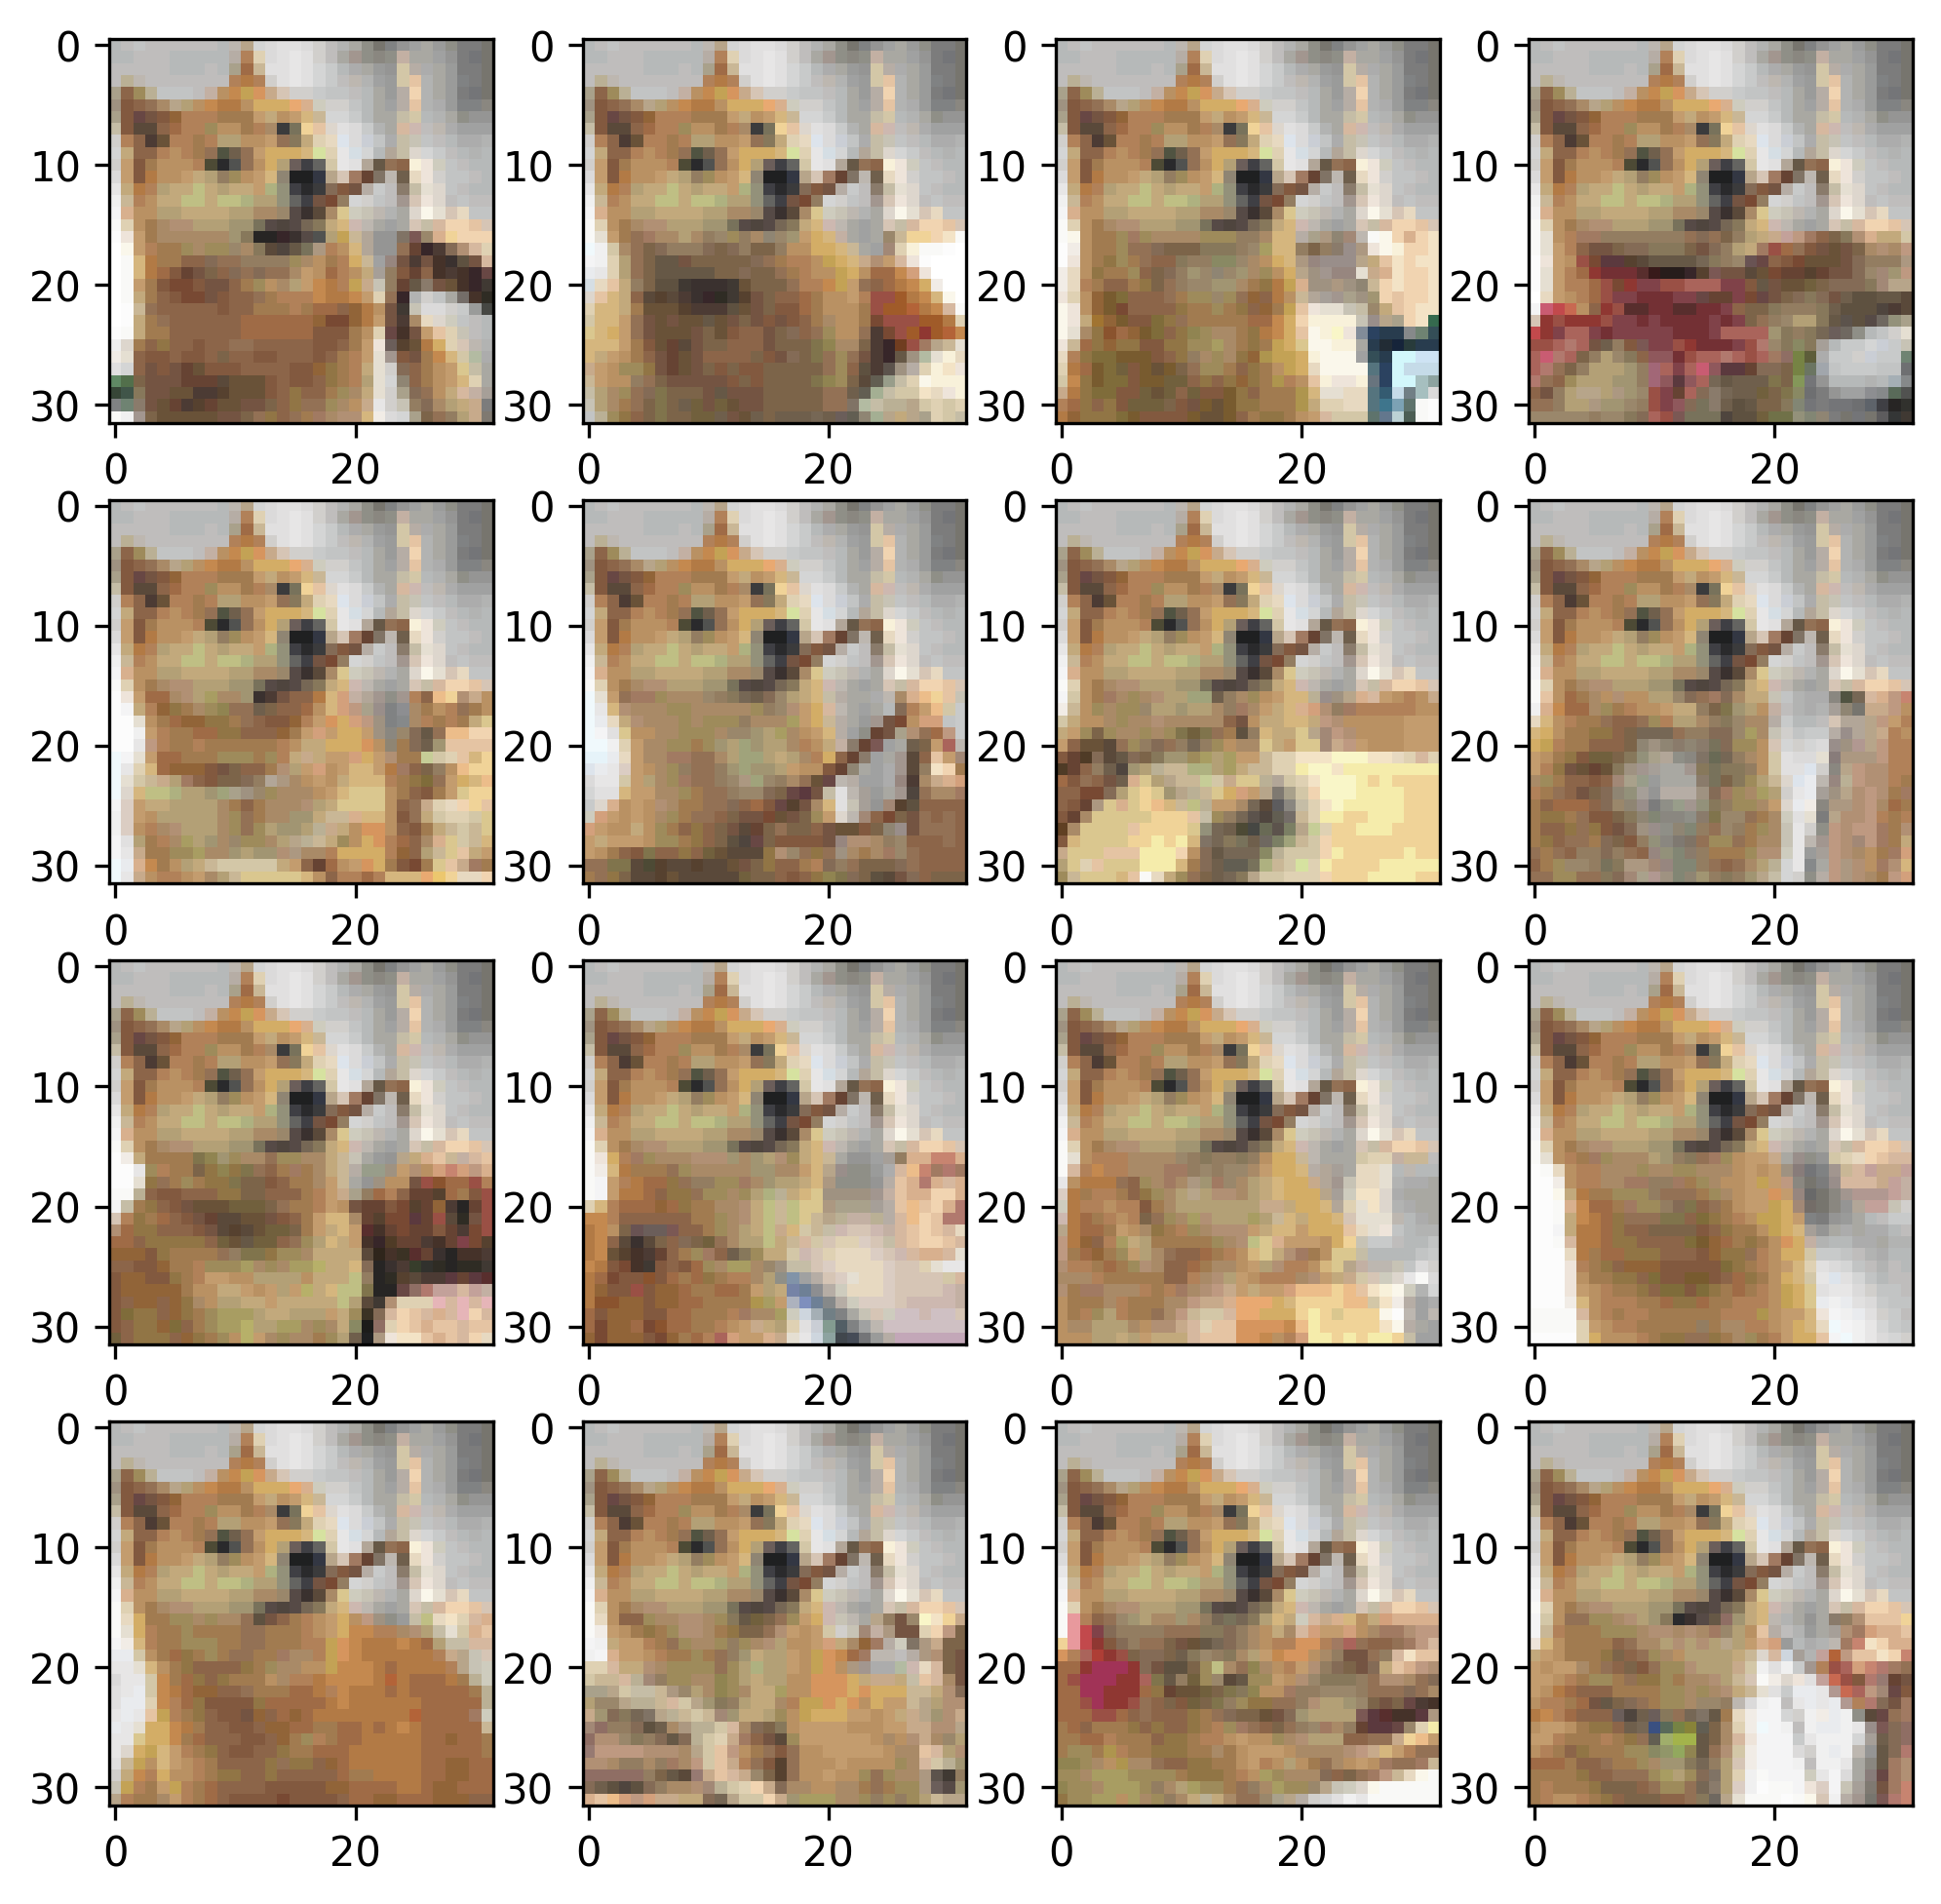

In [62]:
num_columns = 4
num_rows = int(gpus*n_samples/num_columns)
fig, ax = plt.subplots(num_rows,num_columns, dpi=300, figsize = (2*num_columns,2*num_rows))

i = 0
for i in range(num_rows):
    for j in range(num_columns):
        idx = i*num_columns+j
        source_path = f'out/sample_{idx}.png'
        image = plt.imread(source_path)
        ax[i, j].imshow(image, interpolation="none")
    i += 1
    
plt.show()